# Homework 1 Coding Exercises

### 4. Firing Rate of the LIF Model

In [1]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

### a). 
We will use our equation, $T(\bar{I}) = -\tau_m ln(1-\frac{u_{th}-u_{rest}}{R\bar{I}})$, to analyze the time to spike.

In [2]:
R = 1 #ohms
Tau_m = 10 #ms
u_rest = 0 #mV
u_threshold = 1 #mV

Here, $\bar{I}_{crit}=1mA$

In [3]:
%%capture
di = 0.001 # time step
ni = int(np.round(10/di)+1) # number of entries in vector array
I_vec = np.linspace(1.0001,10,ni)

T = np.zeros(ni)

for k in range(ni-1):
    T[k] = -Tau_m * np.log(1 - (1/I_vec[k]))
    
sb.set()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(I_vec, T)
plt.title("Time to Spike")
ax.set_xlabel("Current (mA)")
ax.set_ylabel("Time (ms)")
ax.set_xlim(0,11)
ax.set_ylim(0,50)
#plt.vlines(1,0,100)

### b). 
Using code modified from *lif_mod.py* we will overlay estimated time to spike values for $\bar{I}=1.1mA, \bar{I}=2mA, \bar{I}=5mA, \bar{I}=10mA$.

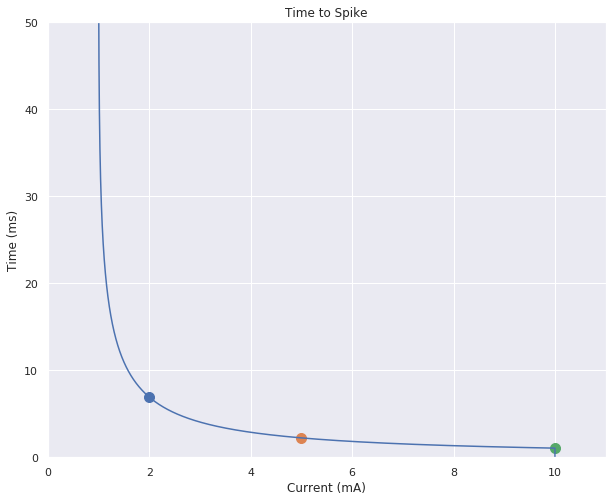

In [4]:
#%%capture

I = [1.1, 2, 5, 10]       # input current (mA)

T = 10      # total time to run
dt = 0.001   # time step
nt = int(np.round(T/dt)+1)     # number of entries in vector array (mV)
tvec = np.linspace(0,T,nt)     # time vector (ms)

#st = 0             # initialize vector of spike times

for i in range(0, len(I)):
    u = np.zeros(nt)   # vector of voltage entries
    for j in np.arange(nt-1):
        u[j+1] = u[j]+dt*(R*I[i]-u[j])/Tau_m;
        
        if u[j+1]>u_threshold:
            u[j+1]=u_rest;                   # reset the voltage to resting potential
            #st = np.append(st,tvec[j+1])    # add on another spike time
            ax.scatter(I[i], tvec[j+1], s=100)
        
            break

fig

### c).
We will now look at our solution from 1.d, $u(t) = u_{rest} + \frac{RASin(t) - RA\tau_mCos(t) + RA\tau e^{-\frac{t}{\tau_m}}}{1 + \tau_m^2}$, and analyze it using modified code from *lif_per.py*. Taking the $\lim_{\tau_m\to\infty}$, which we will approximate numerically, we can then determine the minimum $A_{crit}$ to generate a spike.

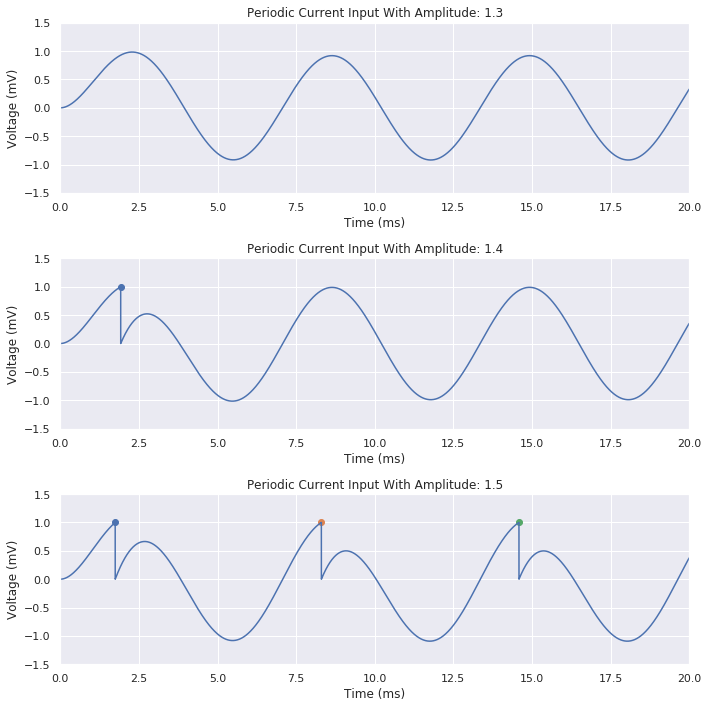

In [5]:
taum = 1    # membrane time constant (ms)
urest = 0   # resting potential (mV)
R = 1       # resistance (ohms)
uth = 1     # spiking threshold (mV)
A_vec = [1.3, 1.4, 1.5]     # current modulation amplitude (mA)

T = 20      # total time to run
dt = 0.001   # time step
nt = int(np.round(T/dt)+1)     # number of entries in vector array
tvec = np.linspace(0,T,nt)

u = np.zeros(nt);   # vector of voltage entries
st = []              # initialize vector to store spike times

fig, ax= plt.subplots(nrows=3, ncols=1,figsize=(10,10))
k=0
sb.set()

for A in A_vec:
    for j in np.arange(nt-1):
        I = A*np.sin(tvec[j])               # 
        u[j+1] = u[j]+dt*(R*I-u[j])/taum    # update the voltage
        if u[j+1]>uth:
            u[j+1]=urest                    # reset the spike voltage
            st = np.append(st,tvec[j+1])    # add spike time to vector

    ax[k].plot(tvec,u)
    ax[k].set_title("Periodic Current Input With Amplitude: " + str(A))
    ax[k].set_xlabel("Time (ms)")
    ax[k].set_ylabel("Voltage (mV)")
    ax[k].set_xlim(0,20)
    ax[k].set_ylim(-1.5,1.5)

    for i in range(0,len(st)):
        try:
            if len(st)==1 or i==len(st)-1 or st[i] < st[i+1]-0.1:
                ax[k].scatter(st[i],1)
        except:
            pass
    
    k = k+1

plt.tight_layout()

Here we have plotted three different cureves for an periodic input of 1.3, 1.4, and 1.5 mA. We can see that at 1.3 mA no spike ocurs and the voltage is simply a sinusoidal curve. However, at 1.4 mA ($A_{crit}$) this is enough to generate a single spike, and with 1.5 mA this is enough to genereate multiple spikes. Note that $A_{crit}$ was determined by plugging in different values and testing.

### 5. Simulating Hodgkin-Huxley

### a).
Here we are editing the code from *hh_spike.py* to determine the minimum input current to generate repetitive spikes -- the rheobase.

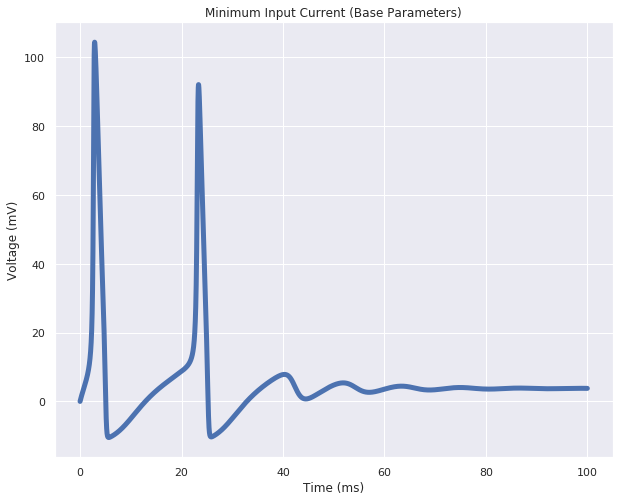

In [6]:
from scipy.integrate import odeint

T = 100.0    # end time (in milliseconds)
gK = 36.0   # average potassium channel conductance per unit area (mS/cm^2)
gNa = 120.0 # average sodium channel conductance per unit area (mS/cm^2)
gL = 0.3    # average leak channel conductance per unit area (mS/cm^2)
Cm = 1.0    # membrane capacitance per unit area (uF/cm^2)
EK = -12.0  # potassium potential (mV)
ENa = 115.0 # Sodium potential (mV)
EL = 10.6   # leak potential (mV)
Id = 6    # input current (mA)

# time vector
tvec = np.linspace(0, T, 10000)

# potassium ion-channel rate functions
def alpha_n(Vm):
    return (0.1-0.01*Vm)/(np.exp(1-0.1*Vm)-1)

def beta_n(Vm):
    return 0.125*np.exp(-Vm/80)

# sodium ion-channel rate functions
def alpha_m(Vm):
    return (2.5-0.1*Vm)/(np.exp(2.5-0.1*Vm)-1)

def beta_m(Vm):
    return 4*np.exp(-Vm/18)

def alpha_h(Vm):
    return 0.07*np.exp(-Vm/20)

def beta_h(Vm):
    return 1/(np.exp(3-0.1*Vm)+1)
  
# n, m, and h steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))
  
# compute derivatives
def compute_derivatives(y, t0):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK/Cm)*np.power(n,4.0)
    GNa = (gNa/Cm)*np.power(m,3.0)*h
    GL = gL/Cm
    
    dy[0] = (Id/Cm)-(GK*(Vm-EK))-(GNa*(Vm-ENa))-(GL*(Vm-EL))
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1-n))-(beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1-m))-(beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1-h))-(beta_h(Vm)*h)
    
    return dy
  
# state (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])

# solve ODE system
# vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])
Vy = odeint(compute_derivatives, Y, tvec)

# plot neuron potential
sb.set()

fig = plt.figure(figsize=(10,8))       
plt.plot(tvec, Vy[:, 0],linewidth=5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title("Minimum Input Current (Base Parameters)")
plt.show()

By modifying the constant current input we can determine the following rheobase values given different parameters.

$$
\text{a)}\;\;\; g_k=36, g_{Na}=120, E_{k}=-12, E_{Na}=115\implies rheobase\approx6mA\\
\text{b)}\;\;\; g_k=30, g_{Na}=120, E_{k}=-12, E_{Na}=115\implies rheobase\approx2.7mA\\
\text{c)}\;\;\; g_k=36, g_{Na}=100, E_{k}=-12, E_{Na}=115\implies rheobase\approx10.85mA\\
\text{d)}\;\;\; g_k=36, g_{Na}=120, E_{k}=0, E_{Na}=115\implies rheobase\approx-2.1mA\\
\text{e)}\;\;\; g_k=36, g_{Na}=120, E_{k}=-12, E_{Na}=100\implies rheobase\approx10.2mA
$$

We can analyze the Hodgkin-Huxley equation to understand why changin these parameters affects the rheobase in any particular way. 

##### b).
Looking at the numbers above we can see that lowering $g_k$ to 30 lowered the rheobase from (a) by 3.3 mA. This makes sense becuase in HH lowering $g_k$ makes it harder for potassium ions to flow through channels in the cell membrane. Potassium ions ($K^+$) are what decrease the neuron voltage, so limiting the flow means the voltage can build and allows for a decreased input current.

##### c).
We can also see that lowering $g_{Na}$ to 100 increased the rheobase from (a) by 4.85 mA. This follows similarily to lowering $g_k$ because lowering $g_{Na}$ makes it more difficult for sodium ions to travel through trans-membrane channels. This in turn makes it harder to spike as sodium ions ($Na^+$) are what increase the voltage in the neuron. This means a higher input current is required to spike.

##### d).
Changing $E_k$ to 0 mV lowers the rheobase from (a) by 8.1 mA (making the minimum current negative). It is reasonable that lowering $E_k$ would do this because one is raising the reversal potential which effectively makes it harder for the neuron voltage to decrease due to Potassium transport. This in turn allows the input current to be lower as the voltage does not decay as much. In fact, it does this to such an extreme extent that current does not even need to be flowing into the cell (this may not be a physically realistic situation).

##### e).
Finally, lowering $E_{Na}$ to 100 mV increases the rheobase from (a) by 4.2 mA. This again follows similarily to changing $E_k$ as decreasing $E_{Na}$ effectively makes it harder for the voltage to build in the cell. This then requries more current to reach a spike. The change to $E_{Na}$ makes it more difficult for sodium ions to travel across the membrane. 